In [100]:
import time
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn 
import time

#xgboost part of this notebook follows {https://github.com/k-woodruff/bdt-tutorial} quite closely. 

In [50]:
muon_df =pd.read_feather("muplus.feather") #read in muon hdf to pandas dataframe
print(f"Number of mu+ events in data set is {len(muon_df)}")

elec_df = pd.read_feather("electrons_large.feather")
print(f"Number of electron envents in data set is {len(elec_df)}")

Number of mu+ events in data set is 456616
Number of electron envents in data set is 303723


In [49]:
#create filtered dataframes only containing events that either start as an electron or a negative muon, respectively
ele_filt = elec_df.loc[elec_df['pdg_id']==11]
mup_filt = muon_df.loc[muon_df['pdg_id']==-13]
#print(ele_filt.shape[0],mum_filt.shape[0]) 

#combine the filtered dataframes
combined_df = pd.concat([ele_filt, mup_filt], ignore_index=True)

#permute the combined dataframe to randomly mix the indices
shuffled_df= combined_df.sample(frac = 1)

#make sure shuffled df looks correct
print(f"Number of total shuffled events: {len(shuffled_df)}")
shuffled_df.head()

#split the shuffled df into a df for training the tree and a df for validating the tree's predictions
shuffled_training_df = shuffled_df.iloc[0:400000]
shuffled_validation_df = shuffled_df.iloc[400000:]

print(f"Number of shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")

Number of total shuffled events: 579431
Number of shuffled events for training: 400000
Number of shuffled events for validation: 179431


,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
90444,0.226996,0.318289,-137.453812,-28.416494,-142.671082,-26.494062,2,0.193887,-14,-1,11
117903,2.078756,2.630933,176.723480,-28.409124,180.675705,-26.376453,7,1.379657,10,-1,11
389060,0.190673,0.261653,212.916061,-28.414724,199.759705,-52.283821,1,0.190673,13,-1,-13
395598,0.276647,0.344119,117.160355,-55.728489,106.626465,-59.390972,1,0.276647,6,-3,-13
310688,0.171027,0.228291,268.667053,29.325758,255.817703,47.420746,1,0.171027,17,1,-13


In [83]:
for col in shuffled_training_df.columns:
    print(col)
print('Fraction e/mu: {}'.format(len(shuffled_training_df[shuffled_training_df.pdg_id == 11])/(float)(len(shuffled_training_df[shuffled_training_df.pdg_id == -13]))))    

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
pdg_id
Fraction e/mu: 0.4696588921711271


We expect the x and y position to be much more important as a training feature than it is with e-/mu-.

In [150]:
#drop columns related to truth quantities and redundant features. Not dropping pdg_id yet, as xgboost uses this as the 'label' for the data
train_df = shuffled_training_df.drop(columns=['x','y','energy'])
val_df = shuffled_validation_df.drop(columns=['x','y','energy'])

#create an index of the columns that we want to be the features that the ML tree investigates as dependent variables
feature_names = train_df.columns[0:-1] #drop the pdg_id, as it is the independent variable in this context
print(feature_names)


#necessary to let xgboost know that the pdg_id is a categorical feature
train_df['pdg_id']=train_df['pdg_id'].astype('category')
val_df['pdg_id']=val_df['pdg_id'].astype('category')
val_df.head()





Index(['energy_cor', 'x_cor', 'y_cor', 'nhits', 'seed_e', 'seed_ix',
       'seed_iy'],
      dtype='object')


,energy_cor,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
575567,0.236619,305.047699,-57.183563,2,0.094982,21,-1,-13
139660,1.458695,-234.198776,-41.778664,6,0.922633,-20,-2,11
415128,0.395857,-197.061264,-40.556244,2,0.166251,-18,-2,-13
224446,0.213612,-104.001617,28.517933,1,0.144588,-11,1,-13
490597,0.279624,145.376907,-46.284313,1,0.197887,9,-1,-13


In [151]:
train = xgb.DMatrix(data=train_df[feature_names],label=train_df.pdg_id.cat.codes, #what is .cat.codes??
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=val_df[feature_names],label=val_df.pdg_id.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [152]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of electron events in training set: {}'.format(len(np.where(train.get_label())[0])))
elec_in_training = format(len(np.where(train.get_label())[0]))

muon_in_training = train_df.shape[0] - int(elec_in_training)
print(f"\nRatio e-/mu+ in training: {int(elec_in_training)/muon_in_training}") #check that we have preserved ratio

Number of training samples: 400000
Number of testing samples: 179431

Number of electron events in training set: 127828

Ratio e-/mu+ in training: 0.4696588921711271


In [153]:
param = {}

# Booster parameters
param['eta']              = .1 # learning rate
param['max_depth']        = 10 # maximum depth of a tree
param['subsample']        = 1 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100 # number of trees to make

In [154]:
#train using xgboost
%%time
booster = xgb.train(param,train,num_boost_round=num_trees)

In [155]:
#evaluate the model using the test dataset
print(booster.eval(test))

[0]	eval-rmse:0.13370461601935887	eval-rmse:0.13370461601935887	eval-rmse:0.13370461601935887


In [156]:
predictions = booster.predict(test)

/tmp/ipykernel_1585/2933838026.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(val_df[val_df.pdg_id == 11]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


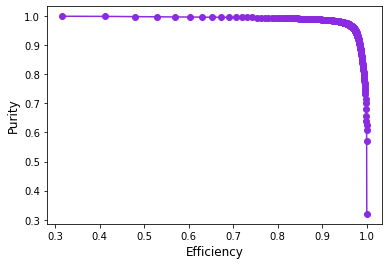

In [157]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(val_df[val_df.pdg_id == 11]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

x and y are very deciding features for xgboost again, no surprises.


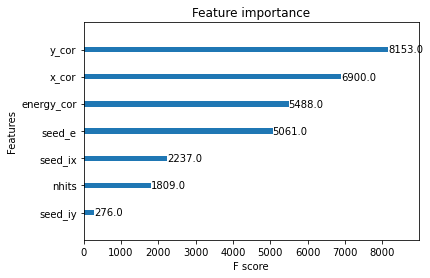

In [159]:
xgb.plot_importance(booster,grid=False);
print("x and y are very deciding features for xgboost again, no surprises.")

In [160]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
import time

In [177]:
%%time
X_train = train_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = train_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = val_df['pdg_id'] #contains truth values for the test set 

#check to make sure we have the same number of entries 
X_train.shape[0]==Y_train.shape[0]
#we do the fitting here
clf.fit(X_train, Y_train)
#test the model 
clf_pred = clf.predict(X_test)
X_test.shape
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu+/e-): %f" % clf.score(X_test, Y_test))
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error")

Training set score (should be very close to 1): 0.999958
Test set score (how accurate the model is at classifying mu+/e-): 0.961718
So using 179431 datapoints, we on average have a 3.828212516231866 % error
CPU times: user 5.03 s, sys: 29.9 ms, total: 5.06 s
Wall time: 5.03 s


In [163]:
A = tree.DecisionTreeClassifier(max_depth=10)
B = tree.DecisionTreeClassifier(max_depth=1)

In [164]:
A.fit(X_train, Y_train)
B.fit(X_train,Y_train)
A.predict(X_test)
B.predict(X_test)
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-A.score(X_test,Y_test))*100} % error")
print(f"Using a 1 layer deep tree, we yield a {(1-B.score(X_test,Y_test))*100} % error")

So using 179431 datapoints, we on average have a 3.1237634522462643 % error
Using a 1 layer deep tree, we yield a 4.325339545563478 % error


In [165]:
A_score = A.score(X_test,Y_test)
B_score = B.score(X_test,Y_test)

In [166]:
print("Test set score (how accurate the model is at classifying mu+/e-): %f" % A.score(X_test, Y_test))

Test set score (how accurate the model is at classifying mu+/e-): 0.968762


In [169]:
sklearn.metrics.f1_score(Y_test,predict, pos_label = -13) #f score

0.969697464115418

In [170]:
A.classes_ #some helpful attributes of the decision tree class
A.max_features_
A.feature_names_in_
A.feature_importances_

array([9.44946146e-01, 7.69210684e-03, 2.01151353e-02, 2.77437066e-03,
       5.31003360e-03, 1.90817291e-02, 8.04787815e-05])

Again, sklearn's tree really only uses the energy of the particle to do classification, even with oppositely charged particles


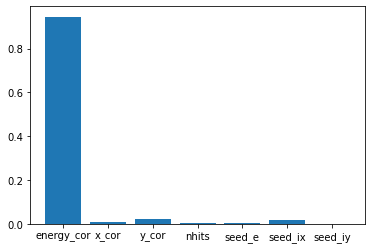

In [171]:
plt.bar(A.feature_names_in_,A.feature_importances_)
print("Again, sklearn's tree really only uses the energy of the particle to do classification, even with oppositely charged particles")

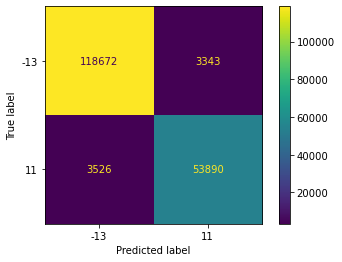

In [178]:
#create and plot the confusion matrix for the normal decision tree
clf_cmatrix = sklearn.metrics.confusion_matrix(Y_test, clf_pred, labels=clf.classes_)
display = sklearn.metrics.ConfusionMatrixDisplay(clf_cmatrix, display_labels=clf.classes_)
display.plot()
plt.show()

In [172]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [173]:
#for fun, we try another kind of classified, recommended for cases with huge data 
hist_gradient_BC = HistGradientBoostingClassifier().fit(X_train,Y_train)

In [174]:
hist_score = hist_gradient_BC.score(X_test,Y_test)

In [175]:
print(f" standard decision tree score: {A_score}, hist gradient score: {hist_score}")

 standard decision tree score: 0.9687623654775374, hist gradient score: 0.9740290139385056


In [176]:
print(f"hist_gradient is {(hist_score - A_score)*100 } % better than the standard classifier")

hist_gradient is 0.5266648460968248 % better than the standard classifier
